# Providing data-driven suggestion for DAEWOO Steel Co. Ltd

## Description and deliverables
This project is an opportunity to analyze dataset and build predictive models that can provide insights to the DAEWOO Steel Co. Ltd.

Upon completion, this will have two artifacts that you would be able to present to the DAEWOO Steel team. One is a brief one-page summary of this project that you would present to external stakeholders as the data professional in DAEWOO Steel Co.Ltd. The other is a complete code notebook provided here. Please consider the prior course work and select one way to achieve this given project question. Either use a regression model or machine learning model to predict whether or not the load type consumption energy is balanced. 

In this deliverables will include the model evaluation (and interpretation if applicable), a data visualization(s) of your choice that is directly related to the question you ask, ethical considerations, and the resources you used to troubleshoot and find answers or solutions.

## Understand the business scenario and problem
The DAEWOO Steel Co. Ltd wants to take some initiatives to improve energy consumptions at the company. They collected data from electricity consumption is held in a cloud-based system, but now they don’t know what to do with it. They have the following question: what’s likely to make the energy consumption Heavy Load?

The goals in this project are to analyze the data collected by the DAEWOO Steel Co. Ltd and to build a model that predicts whether or not the energy consumption is balanced or overused.

#### Import Packages

In [2]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

#### Load Dataset

In [4]:
# Load dataset into a dataframe
df = pd.read_csv("steel_industry_data.csv")

# Display first few rows of the dataframe 
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


## Data Exploration (Initial EDA and data cleaning)
- Understand the variables
- Clean the dataset (if any missing data, redudant data, outliers)

### Gather basic information about the data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

### Gather descriptive statistics about the data

In [12]:
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


### Rename columns
As a data cleaning step, rename the columns as needed. Standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [15]:
df.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [17]:
df = df.rename(columns={
                        'Usage_kWh': 'Usage_kWh',
                        'Lagging_Current_Reactive.Power_kVarh': 'Lagging_Reactive_Power_kVarh',
                        'Leading_Current_Reactive_Power_kVarh': 'Leading_Reactive_Power_kVarh',
                        'CO2(tCO2)': 'CO2_Emissions_tCO2',
                        'Lagging_Current_Power_Factor': 'Lagging_Power_Factor',
                        'Leading_Current_Power_Factor': 'Leading_Power_Factor',
                        'NSM': 'NSM',
                        'WeekStatus': 'Week_Status',
                        'Day_of_week': 'Day_of_Week',
                        'Load_Type': 'Load_Type'
                        })
df.columns

Index(['date', 'Usage_kWh', 'Lagging_Reactive_Power_kVarh',
       'Leading_Reactive_Power_kVarh', 'CO2_Emissions_tCO2',
       'Lagging_Power_Factor', 'Leading_Power_Factor', 'NSM', 'Week_Status',
       'Day_of_Week', 'Load_Type'],
      dtype='object')

### Check missing values

Check for any missing values in the data.

In [21]:
df.isna().sum()

date                            0
Usage_kWh                       0
Lagging_Reactive_Power_kVarh    0
Leading_Reactive_Power_kVarh    0
CO2_Emissions_tCO2              0
Lagging_Power_Factor            0
Leading_Power_Factor            0
NSM                             0
Week_Status                     0
Day_of_Week                     0
Load_Type                       0
dtype: int64

There are no missing values in the data.

### Check duplicates
Check for any duplicates entry in the data.

In [25]:
df.duplicated().sum()

0

There are no duplicates values in the data.

### Check outliers
Check for outliers in the data.

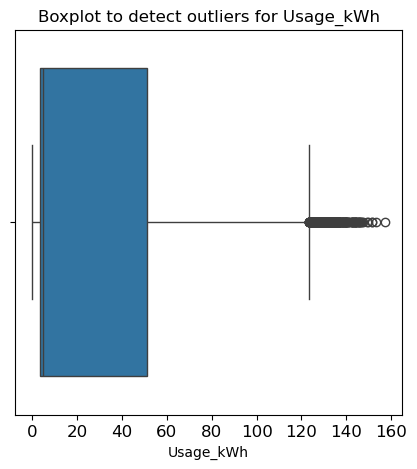

In [29]:
plt.figure(figsize=(5,5))
plt.title('Boxplot to detect outliers for Usage_kWh', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['Usage_kWh'])
plt.show()

The boxplot above shows that there are outliers in `Usage_kWh` variable.

It would be helpful to investigate how many rows in the data contain outliers in the `Usage_kWh` column.

In [196]:
# Compute the 25th percentile value in `Usage_kWh`
percentile25 = df['Usage_kWh'].quantile(0.25)

# Compute the 75th percentile value in `Usage_kWh`
percentile75 = df['Usage_kWh'].quantile(0.75)

# Compute the interquartile range in `Usage_kWh`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `Usage_kWh`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `Usage_kWh`
outliers = df[(df['Usage_kWh'] > upper_limit) | (df['Usage_kWh'] < lower_limit)]

# Count how many rows in the data contain outliers in `Usage_kWh`
print("Number of rows in the data containing outliers in `Usage_kWh`:", len(outliers))

Lower limit: -68.85624999999999
Upper limit: 123.29374999999999
Number of rows in the data containing outliers in `Usage_kWh`: 328


Certain types of models are more sensitive to outliers than others. When you get to the stage of building your model, consider whether to remove these outliers based on the type of model decide to use.

## Data Exploration (Continue EDA)

### Data Visualization
Now, start examining the variables that are interested, and create plots to visualize relationships between variables in the data.

could start by creating a stacked boxplot showing Usage_kWh distributions for CO2_Emissions_tCO2, comparing the distributions of the amount of electricity consumed versus The amount of carbon dioxide emissions produced during energy consumption.

Box plots are very useful in visualizing distributions within data, but they can be deceiving without the context of how big the sample sizes that they represent are. So, you could also plot a stacked histogram to visualize the distribution of CO2_Emissions_tCO2 for load category that shows the level of energy consumption at that time, such as `Light_Load`. This can help in understanding energy consumption patterns in the company.

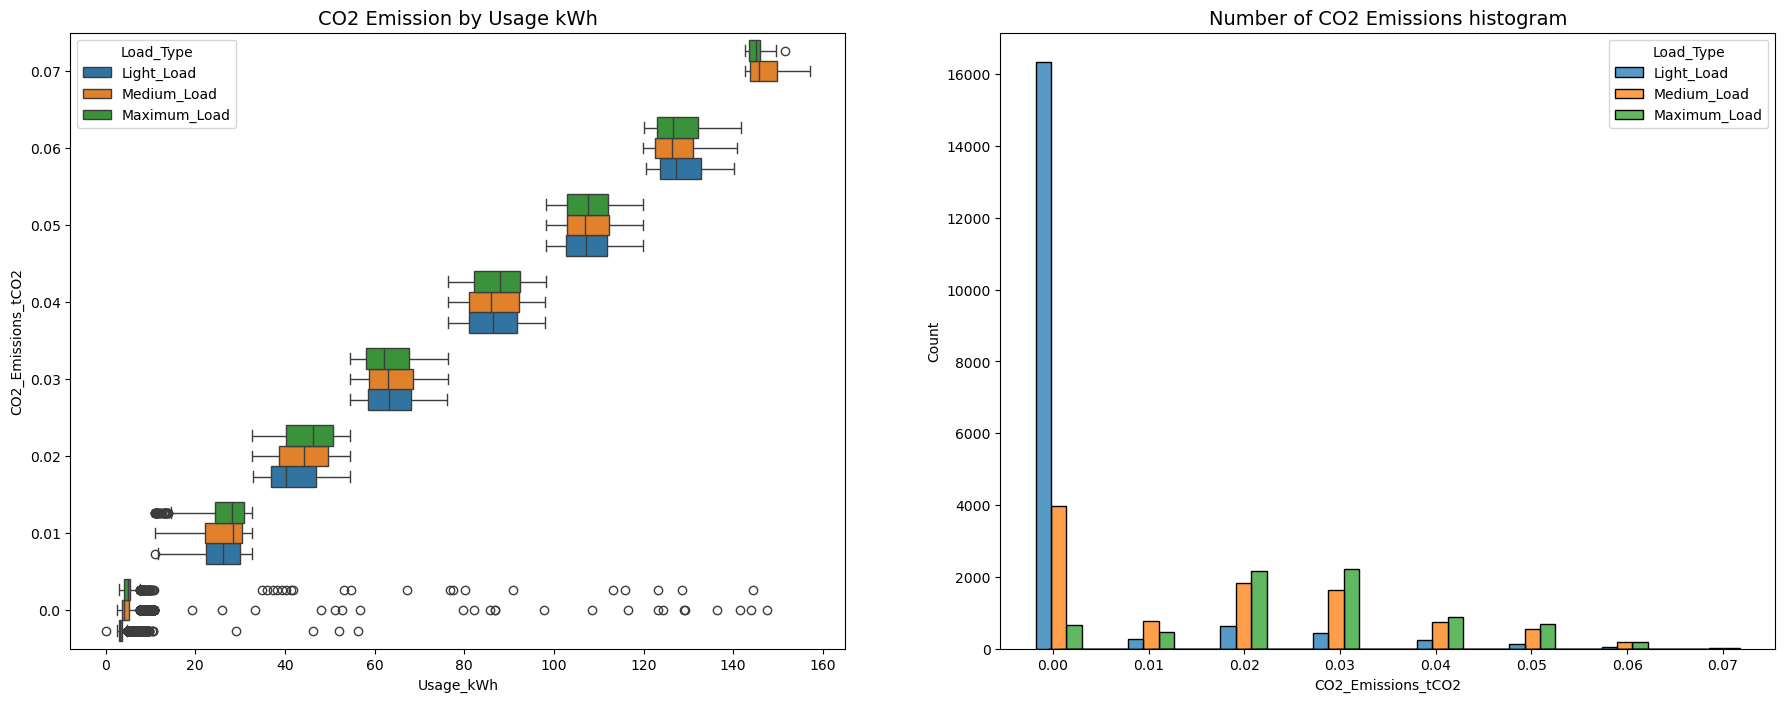

In [36]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize=(22, 8))

# Create boxplot showing `Usage_kWh` distributions for `Load_Type`, comparing energy consumptions
sns.boxplot(data=df, x='Usage_kWh', y='CO2_Emissions_tCO2', hue='Load_Type', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('CO2 Emission by Usage kWh', fontsize='14')

# Create histogram showing distribution of `CO2_Emissions_tCO2`, comparing Load_Type
sns.histplot(data=df, x='CO2_Emissions_tCO2', hue='Load_Type', multiple='dodge', shrink=4, ax=ax[1])
ax[1].set_title('Number of CO2 Emissions histogram', fontsize='14')

# Display the plots
plt.show()

1. Higher electricity usage tends to result in higher CO₂ emissions (ppm) across all load categories. This indicates that energy-intensive consumption correlates with higher CO₂ concentration in the environment or in system outputs.

2. Maximum Load generally produces slightly higher CO₂ emissions at the same consumption levels compared to Light Load and Medium Load. This suggests that under heavy load conditions, the system might operate less efficiently, leading to higher emissions per kWh.
 
3. As electricity usage increases, the spread of CO₂ emissions also widens, with a larger interquartile range (IQR). This indicates greater variability in emissions, possibly due to operational inefficiencies or varying energy sources used at higher consumption levels. Outliers appear mostly in low to medium electricity usage, suggesting there are specific conditions or cases where emissions do not align with typical patterns (e.g., maintenance issues, differences in energy sources, or operational anomalies).


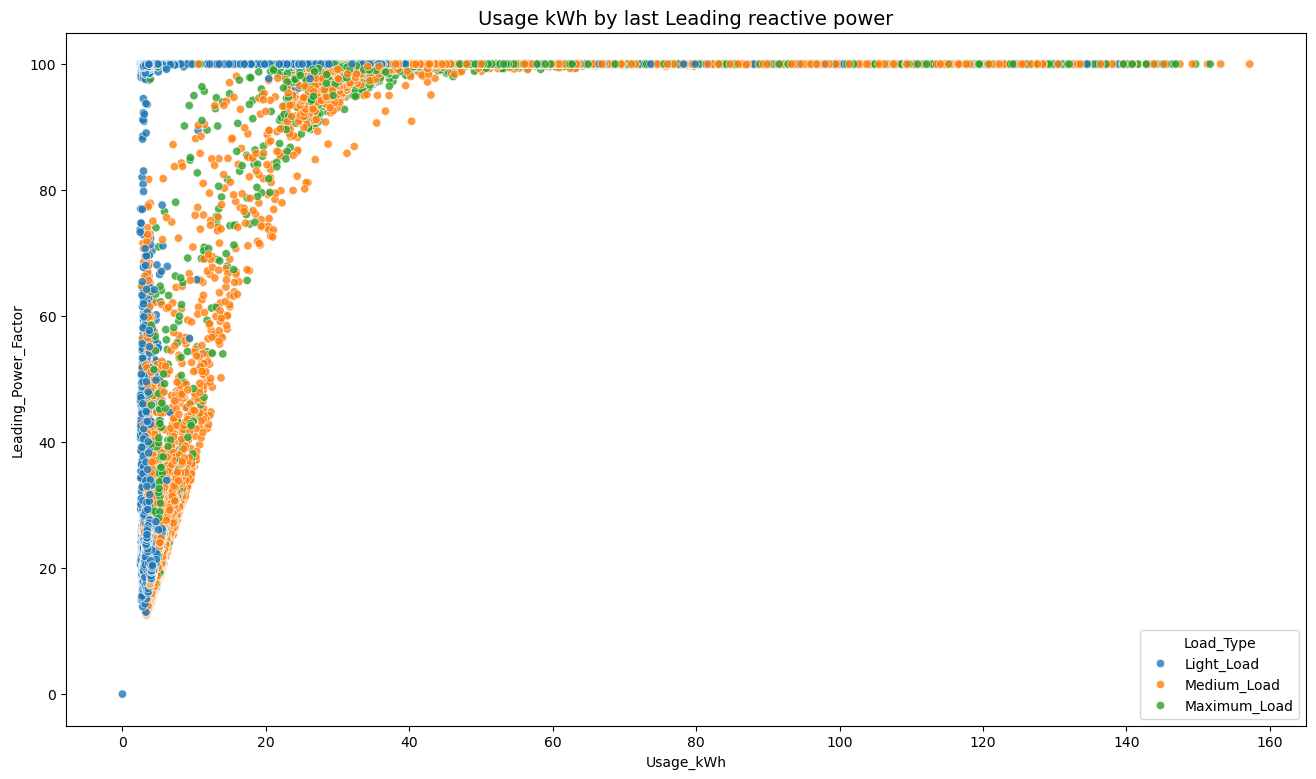

In [72]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='Usage_kWh', y='Leading_Power_Factor', hue='Load_Type', alpha=0.8)
plt.title('Usage kWh by last Leading reactive power', fontsize='14');

The data shows that the most points are concentrated near 100% power factor, indicating optimal or near-optimal energy efficiency for the majority of observations. However, as the power factor decreases, the efficiency drops, with values ranging between 0% and 40% for some cases.

The light is concentrated on the left side of the plot, representing lower electricity usage, but it exhibits high variability in power factor, suggesting inconsistent energy efficiency at low consumptions levels. Medium Load spans a broader range of power usage and tends to stabilize at higher power factor values, moving closer to 100%. Maximum Load primarily appears at higher consumption levels and shows a strong tendency toward high efficiency, with most points clustered near 100% power factor.

As the next step in analyzing the data, calculate the mean and median Load Type of the energy consumption where Light Load, Medium Load and Maximum Load.

In [77]:
df.groupby(['Load_Type'])['Usage_kWh'].agg(['mean', 'median'])

,mean,median
Load_Type,,
Light_Load,8.626207,3.310
Maximum_Load,59.265314,56.630
Medium_Load,38.445394,34.435


The data shows that Light Load has the lowest consumption, indicating skewness toward lower values. Medium Load suggests more balanced usage, while Maximum Load reflects consistently high consumption with minimal skew. As load increases, both average and typical usage rise, with higher loads displaying more stable patterns.

Next, examine energy consumptions for different days.

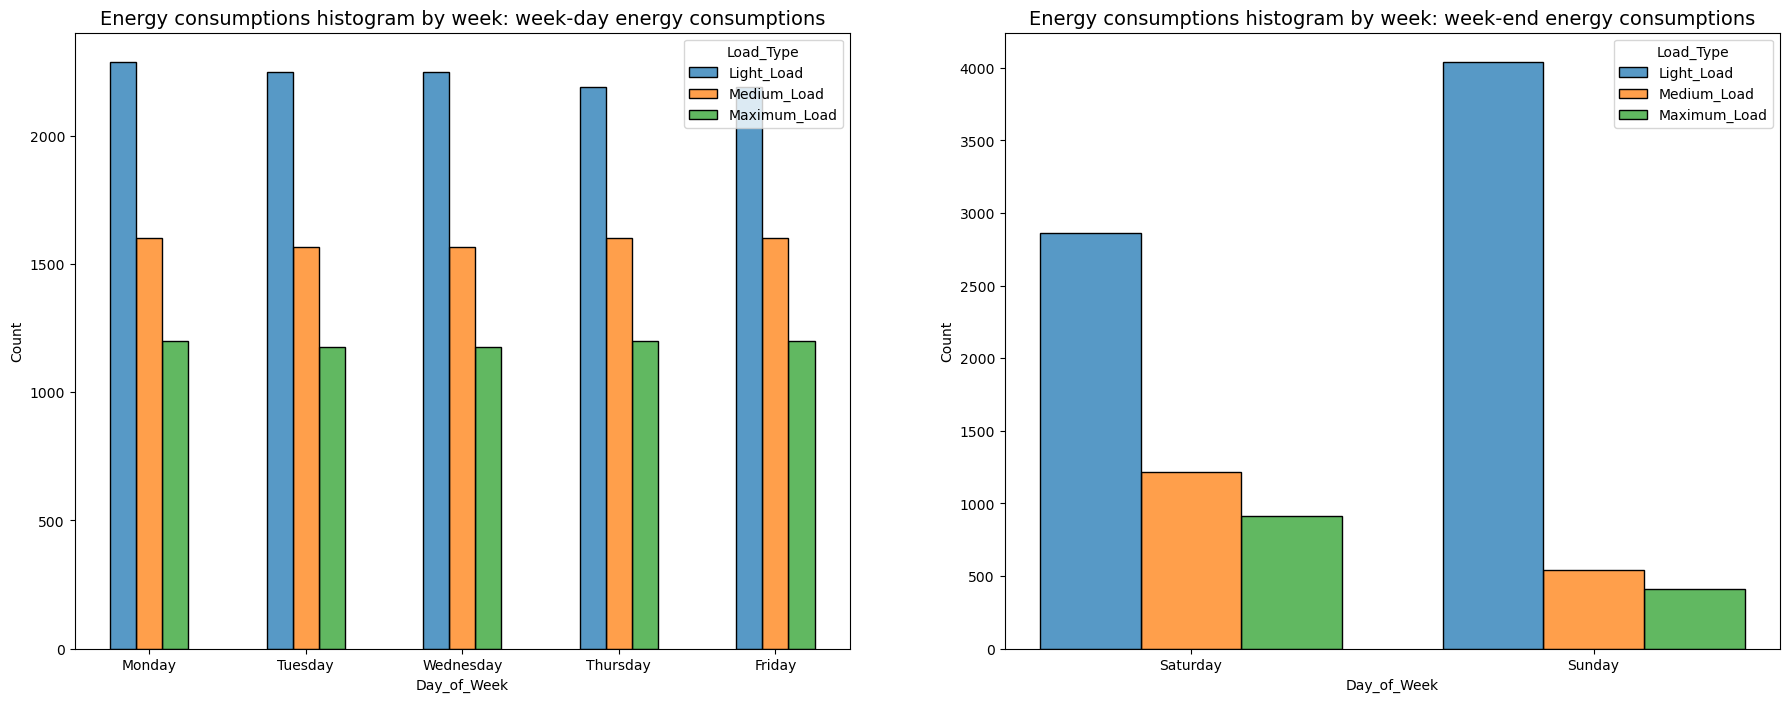

In [194]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

weekday_status = df[df['Day_of_Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekend_status = df[df['Day_of_Week'].isin(['Saturday', 'Sunday'])]

# Plot week-day histogram
sns.histplot(data=weekday_status, x='Day_of_Week', hue='Load_Type', discrete=1, 
             hue_order=['Light_Load', 'Medium_Load', 'Maximum_Load'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Energy consumptions histogram by week: week-day energy consumptions', fontsize='14')

# Plot week-end histogram
sns.histplot(data=weekend_status, x='Day_of_Week', hue='Load_Type', discrete=1, 
             hue_order=['Light_Load', 'Medium_Load', 'Maximum_Load'], multiple='dodge', shrink=.75, ax=ax[1])
ax[1].set_title('Energy consumptions histogram by week: week-end energy consumptions', fontsize='14')
plt.show();

The plots above show that energy consumption is higher on weekdays, dominated by light loads, while weekends, especially Sunday, see a significant decrease across all load types.

Next, inspect how the energy consumptions distributed across energy consumptions.

In [133]:
df['Load_Type'].value_counts()

Load_Type
Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64

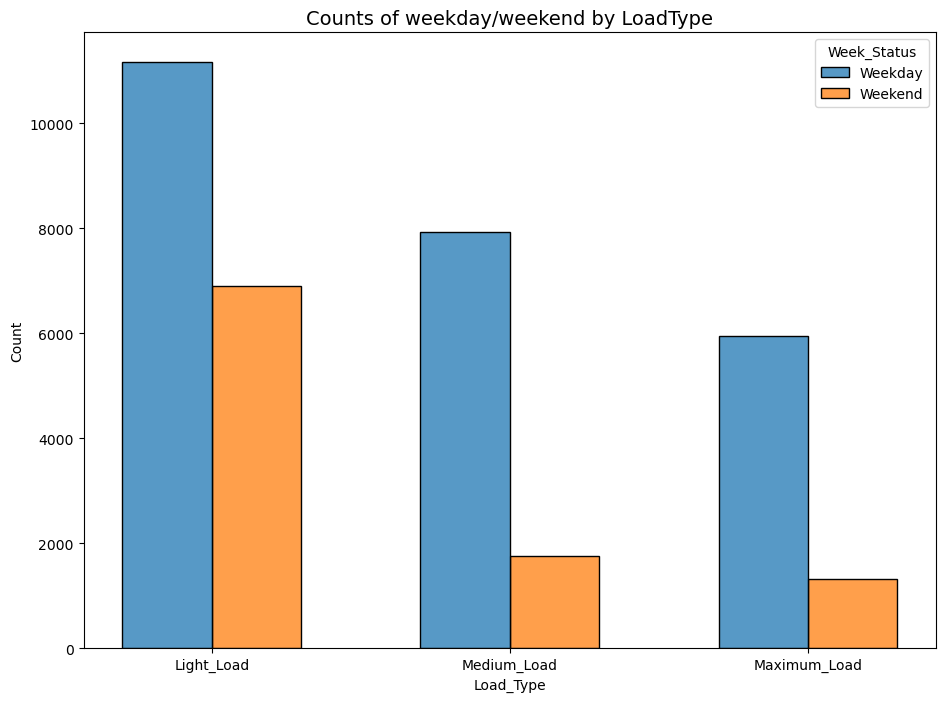

In [155]:
plt.figure(figsize=(11,8))
sns.histplot(data=df, x='Load_Type', hue='Week_Status', discrete=1, 
             hue_order=['Weekday', 'Weekend'], multiple='dodge', shrink=.6)
plt.title('Counts of weekday/weekend by LoadType', fontsize=14);

There doesn't seem to be any Load Type that differs significantly in its proportion of energy consumptions is light, medium and maximum.

Lastly, check for strong correlations between variables in the data.

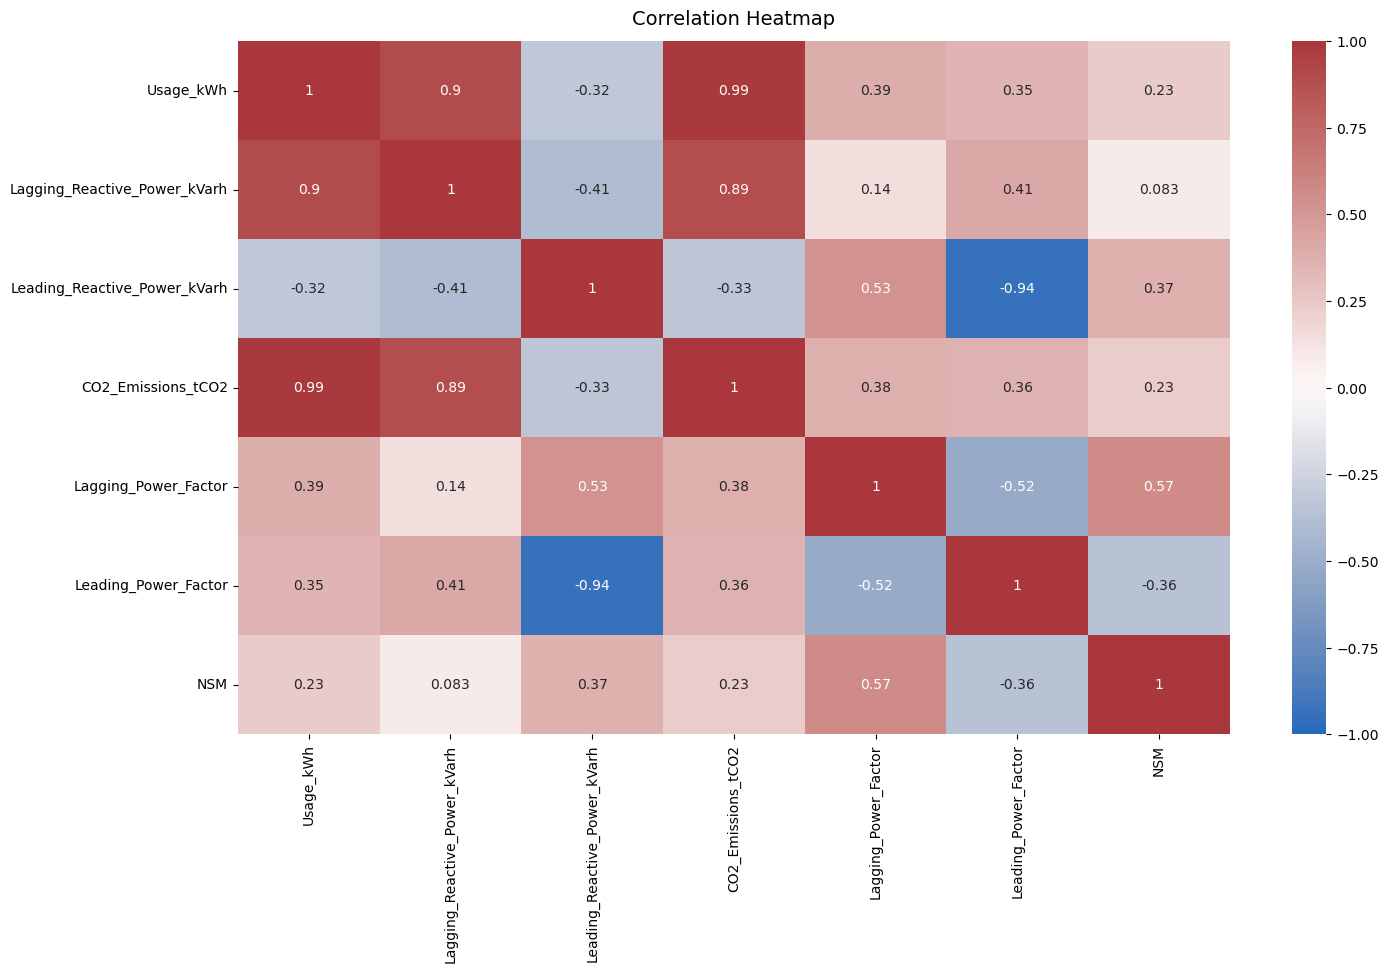

In [161]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Now plot the heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()

The correlation heatmap confirms that the usage kwh, lagging reactive power, and co2 emission all have some positive correlation with each other.

### Insights

There is a clear positive correlation between kWh usage, lagging reactive power, and CO2 emissions, indicating that as energy consumption increases, both reactive power and emissions rise in tandem. This relationship highlights a direct link between energy inefficiency and environmental impact. The positive correlation between lagging reactive power and energy consumption points to potential inefficiencies in the system, where high reactive power suggests that the system is not utilizing energy effectively, leading to unnecessary losses.

The strong connection between energy consumption and CO2 emissions underscores the challenge of reducing carbon footprints, as energy inefficiencies can cause any increase in usage to result in a proportional rise in emissions. Addressing these inefficiencies is crucial for sustainability efforts. By focusing on reducing reactive power and optimizing energy usage, organizations could significantly decrease CO2 emissions, enhancing both operational efficiency and environmental sustainability.

## Recall model assumptions

**Logistic Regression model assumptions**

- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

## Model Building, Results and Evaluation

- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.
the goal is to predict whether the energy consumptions, which is a categorical outcome variable. So this task involves classification. More specifically, this involves binary classification, since the outcome variable load type can be either High (indicating high energy consumption) or Low (indicating low energy consumption).



### Identify the types of models most appropriate for this task.
Since the variable you want to predict (whether the energy consumptions is high) is categorical, you could either build a Logistic Regression model, or a Tree-based Machine Learning model.

So you could proceed with one of the two following approaches. Or, if you'd like, you could implement both and determine how they compare.

### Modelling Approach A: Logistic Regression Model
This approach covers implementation of Logistic Regression.

****Logistic regression****

Note that binomial logistic regression suits the task because it involves binary classification.

Start by one-hot encoding the categorical variables as needed.

In [350]:
# One-hot encode for categorical variable
df_enc = pd.get_dummies(df, prefix=['Load_Type', 'Week_Status'], columns=['Load_Type', 'Week_Status'], drop_first=False)
df_enc = df_enc.applymap(lambda x: int(x) if isinstance(x, bool) else x)

if 'Load_Type' in df_enc.columns and 'Week_Status' in df_enc.columns:
    df_enc[['Load_Type', 'Week_Status']] = df_enc[['Load_Type', 'Week_Status']].astype(int)

# Show dataframe
df_enc.head()

C:\Users\rflip\AppData\Local\Temp\ipykernel_31020\2371615392.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_enc = df_enc.applymap(lambda x: int(x) if isinstance(x, bool) else x)


,date,Usage_kWh,Lagging_Reactive_Power_kVarh,Leading_Reactive_Power_kVarh,CO2_Emissions_tCO2,Lagging_Power_Factor,Leading_Power_Factor,NSM,Day_of_Week,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load,Week_Status_Weekday,Week_Status_Weekend
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Monday,1,0,0,1,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Monday,1,0,0,1,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Monday,1,0,0,1,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Monday,1,0,0,1,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Monday,1,0,0,1,0


In [352]:
df_enc.head()

,date,Usage_kWh,Lagging_Reactive_Power_kVarh,Leading_Reactive_Power_kVarh,CO2_Emissions_tCO2,Lagging_Power_Factor,Leading_Power_Factor,NSM,Day_of_Week,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load,Week_Status_Weekday,Week_Status_Weekend
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Monday,1,0,0,1,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Monday,1,0,0,1,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Monday,1,0,0,1,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Monday,1,0,0,1,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Monday,1,0,0,1,0


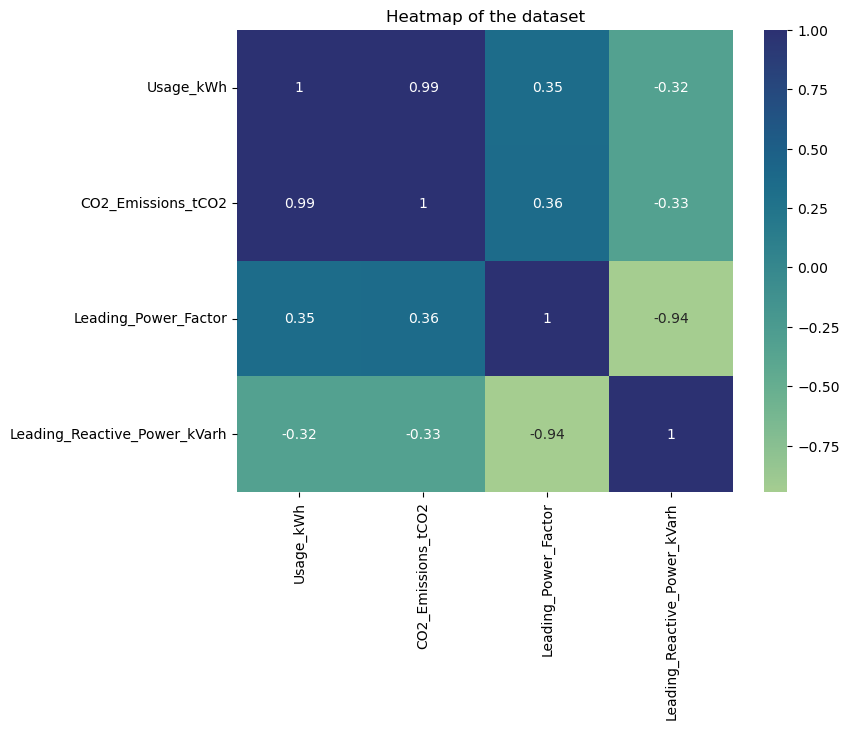

In [354]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['Usage_kWh', 'CO2_Emissions_tCO2','Leading_Power_Factor','Leading_Reactive_Power_kVarh']].corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

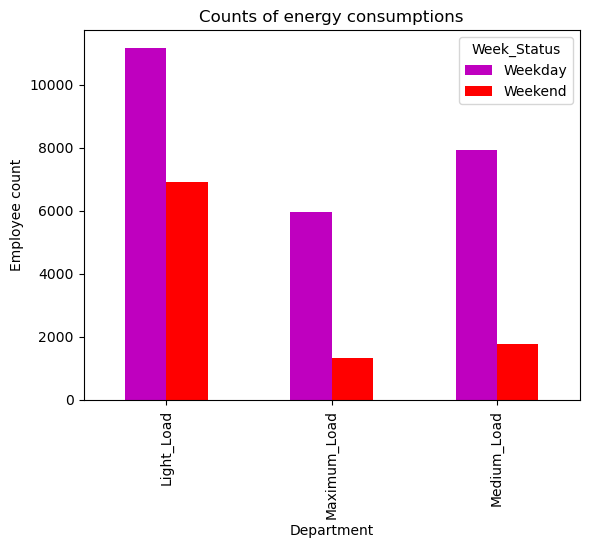

In [356]:
# Create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df["Load_Type"], df["Week_Status"]).plot(kind ='bar',color='mr')
plt.title('Counts of energy consumptions')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

Since logistic regression is quite sensitive to outliers, it would be a good idea at this stage to remove the outliers in the tenure column that were identified earlier.

In [358]:
# Select rows without outliers in `Usage_kWh` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['Usage_kWh'] >= lower_limit) & (df_enc['Usage_kWh'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

,date,Usage_kWh,Lagging_Reactive_Power_kVarh,Leading_Reactive_Power_kVarh,CO2_Emissions_tCO2,Lagging_Power_Factor,Leading_Power_Factor,NSM,Day_of_Week,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load,Week_Status_Weekday,Week_Status_Weekend
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Monday,1,0,0,1,0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Monday,1,0,0,1,0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Monday,1,0,0,1,0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Monday,1,0,0,1,0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Monday,1,0,0,1,0


In [360]:
y = df_logreg['Load_Type_Light_Load']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Load_Type_Light_Load, dtype: int64

Select the features you want to use in your model. Consider which variables will help you predict the outcome variable, `Load_Type_Light_Load`.

In [364]:
# Select the features you want to use in your model
X = df_logreg[['Usage_kWh', 'Lagging_Reactive_Power_kVarh', 'Leading_Reactive_Power_kVarh', 
                      'CO2_Emissions_tCO2', 'Lagging_Power_Factor', 'Leading_Power_Factor', 
                      'NSM', 'Load_Type_Light_Load', 'Load_Type_Maximum_Load', 
                      'Load_Type_Medium_Load', 'Week_Status_Weekday', 'Week_Status_Weekend']]

# Display the first few rows of the selected features 
X.head()

,Usage_kWh,Lagging_Reactive_Power_kVarh,Leading_Reactive_Power_kVarh,CO2_Emissions_tCO2,Lagging_Power_Factor,Leading_Power_Factor,NSM,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load,Week_Status_Weekday,Week_Status_Weekend
0,3.17,2.95,0.0,0.0,73.21,100.0,900,1,0,0,1,0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,1,0,0,1,0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,1,0,0,1,0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,1,0,0,1,0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,1,0,0,1,0


Split the data into training set and test set.

In [366]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Construct a logistic regression model and fit it to the training dataset.



In [369]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

C:\Users\rflip\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test the logistic regression model: use the model to make predictions on the test set.

In [371]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

Create a confusion matrix to visualize the results of the logistic regression model.



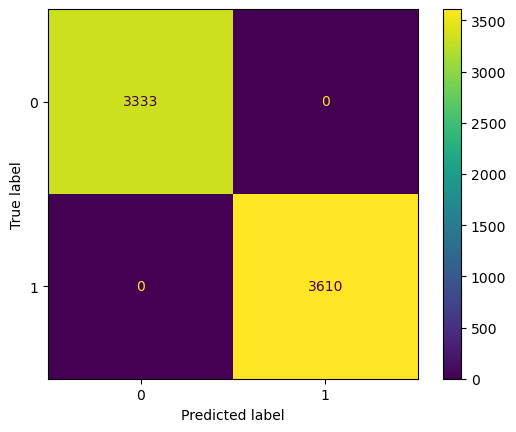

In [373]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives, representing instances where the model accurately predicted energy consumption levels as normal, and the actual usage was indeed balanced. The upper-right quadrant displays the number of false positives, where the model incorrectly predicted excessive energy consumption when it was actually balanced. The bottom-left quadrant displays the number of false negatives, where the model failed to detect excessive energy usage, incorrectly predicting it as balanced. Finally, the bottom-right quadrant displays the number of true positives, where the model correctly identified excessive energy consumption.

- True negatives: The number of cases where energy consumption was balanced, and the model accurately predicted this balance.
- False positives: The number of cases where energy consumption was balanced, but the model inaccurately predicted excessive usage.
- False negatives: The number of cases where energy consumption was excessive, but the model inaccurately predicted it as balanced.
- True positives: The number of cases where energy consumption was excessive, and the model accurately predicted this excessive usage.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.



Check the class balance in the data. In other words, check the value counts in the `Load_Type` column. Since this is a binary classification task, the class balance informs the way you interpret accuracy metrics.

In [379]:
df_logreg['Load_Type_Maximum_Load'].value_counts(normalize=True)

Load_Type_Maximum_Load
0    0.794797
1    0.205203
Name: proportion, dtype: float64

There is an approximately 79%-20% split. So the data is not perfectly balanced, but it is not too imbalanced. If it was more severely imbalanced, you might want to resample the data to make it more balanced. In this case, you can use this data without modifying the class balance and continue evaluating the model.

In [381]:
# Create classification report for logistic regression model
target_names = ['Predicted energy consumption balance', 'Predicted energy consumption imbalance']
print(classification_report(y_test, y_pred, target_names=target_names))

                                        precision    recall  f1-score   support

  Predicted energy consumption balance       1.00      1.00      1.00      3333
Predicted energy consumption imbalance       1.00      1.00      1.00      3610

                              accuracy                           1.00      6943
                             macro avg       1.00      1.00      1.00      6943
                          weighted avg       1.00      1.00      1.00      6943



The classification report above shows that the logistic regression model achieved a 100% precisio, recall and f1-score

### Modelling approach B: Tree-Based Model
This approach covers implementation of Decision Tree and Random Forest.



Encode the categorical variables.


In [388]:
df1 = pd.get_dummies(df)

Isolate the outcome variables.

In [393]:
# Isolate the outcome variable
y = df1['Load_Type_Maximum_Load']

# Display the first few rows of `y`
y.head()

0    False
1    False
2    False
3    False
4    False
Name: Load_Type_Maximum_Load, dtype: bool

In [395]:
# Select the features
X = df1.drop('Load_Type_Maximum_Load', axis=1)

# Display the first few rows of `X`
X.head()

,date,Usage_kWh,Lagging_Reactive_Power_kVarh,Leading_Reactive_Power_kVarh,CO2_Emissions_tCO2,Lagging_Power_Factor,Leading_Power_Factor,NSM,Week_Status_Weekday,Week_Status_Weekend,Day_of_Week_Friday,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,Load_Type_Light_Load,Load_Type_Medium_Load
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,True,False,False,True,False,False,False,False,False,True,False
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,True,False,False,True,False,False,False,False,False,True,False
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,True,False,False,True,False,False,False,False,False,True,False
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,True,False,False,True,False,False,False,False,False,True,False
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,True,False,False,True,False,False,False,False,False,True,False
